In [4]:
import os
from google.cloud import bigquery

# Setting the variable for authentication by using bigquery to access the data
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/jk/Python/key/bigquery.json"

client = bigquery.Client(project="crucial-alpha-174913")




In [5]:
#Query for 2 years data as example
trip_2year = "SELECT * FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` WHERE trip_start_timestamp >= '2022-01-01'" 

df = client.query(trip_2year).to_dataframe()

E0000 00:00:1759542666.712287  772500 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [6]:
#hadling any missing values in the trip_seconds column (0 should not be existed)
df = df[df['trip_seconds']>0]



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly
import matplotlib.dates as mdates
#import all of the neceassary libraries

In [5]:
df['Month'] = df['trip_start_timestamp'].dt.month
df['Year'] = df['trip_start_timestamp'].dt.year

In [6]:
df['year_month'] = df['trip_start_timestamp'].dt.to_period('M')
trend_data = df.set_index('trip_start_timestamp').groupby(pd.Grouper(freq='M')).agg(trips = ('fare','count'),avg_fare = ('fare','mean'), avg_miles = ('trip_miles','mean')).reset_index(names = 'year_month')


/var/folders/26/r7gb_vfx1fzdcf0xczs61z2w0000gn/T/ipykernel_7042/1152529877.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['trip_start_timestamp'].dt.to_period('M')
/var/folders/26/r7gb_vfx1fzdcf0xczs61z2w0000gn/T/ipykernel_7042/1152529877.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  trend_data = df.set_index('trip_start_timestamp').groupby(pd.Grouper(freq='M')).agg(trips = ('fare','count'),avg_fare = ('fare','mean'), avg_miles = ('trip_miles','mean')).reset_index(names = 'year_month')


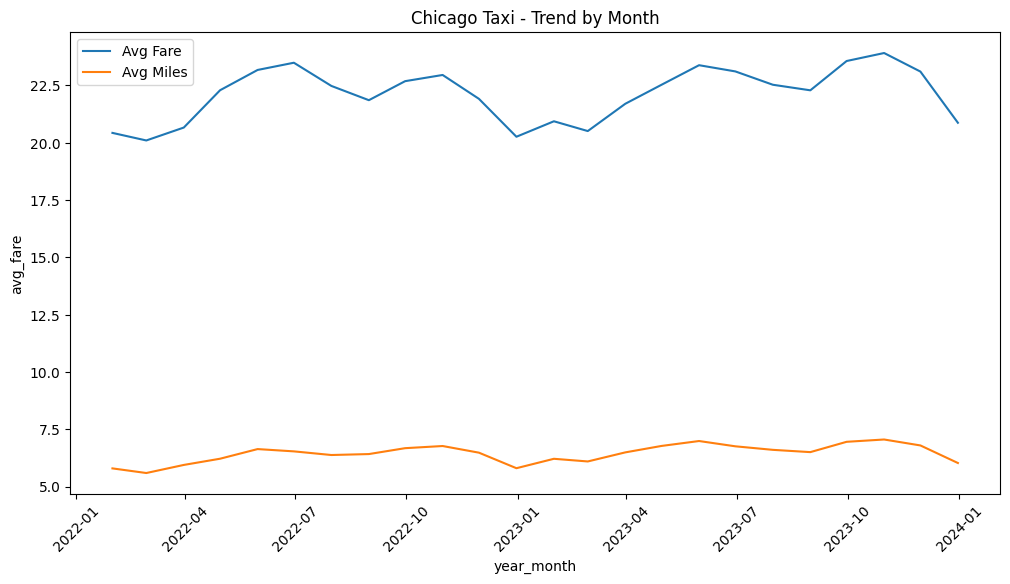

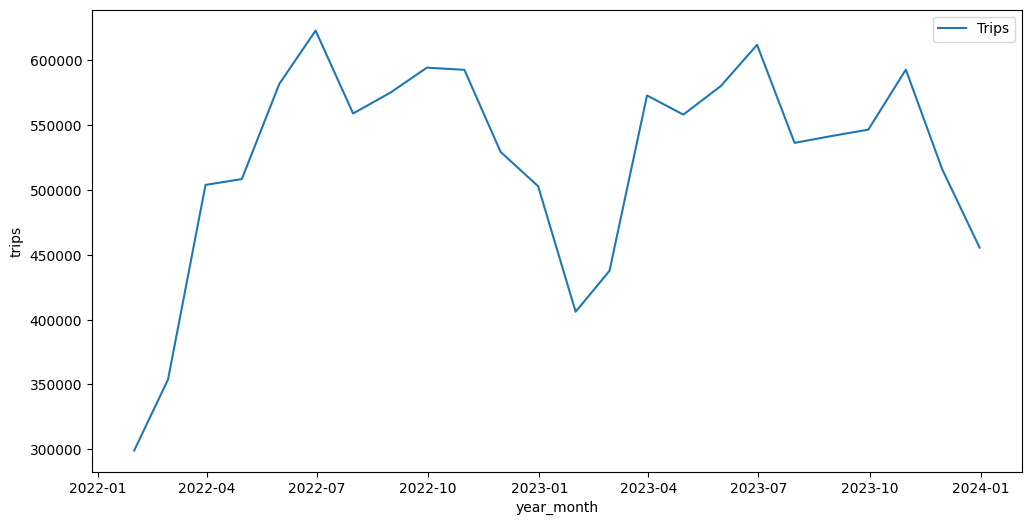

In [ ]:
plt.figure(figsize=(12,6))
# sns.lineplot(data = trend_data, x= 'year_month', y = 'trips', label = 'Trips')
sns.lineplot(data=trend_data, x='year_month', y='avg_fare', label='Avg Fare')
sns.lineplot(data=trend_data, x='year_month', y='avg_miles', label='Avg Miles')
plt.xticks(rotation=45)
plt.title("Chicago Taxi - Trend by Month")
plt.show()
plt.figure(figsize=(12,6))
sns.lineplot(data = trend_data, x= 'year_month', y = 'trips', label = 'Trips')
plt.show()
#plotting the trend chart for avg fare, avg miles and trips by month

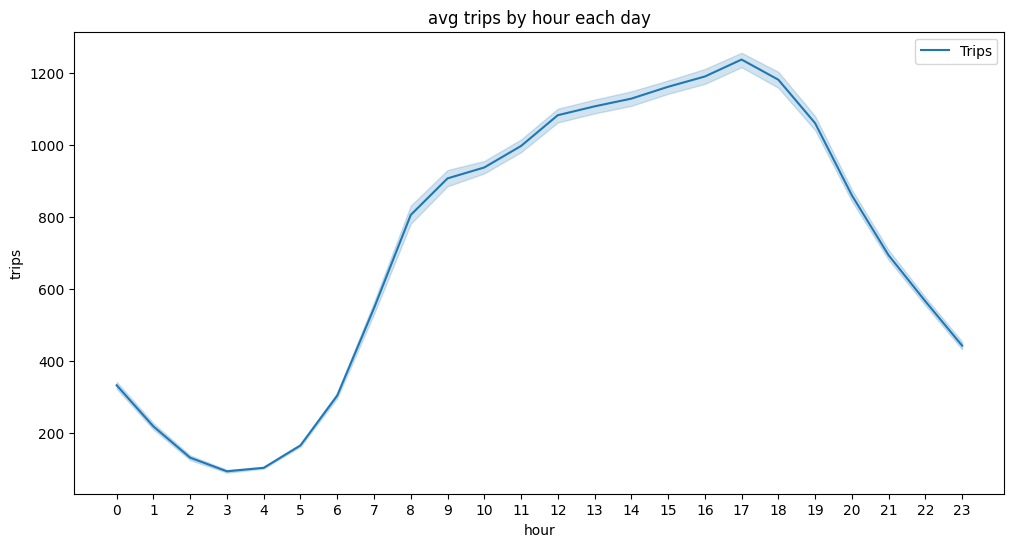

In [8]:
hour_data = df.set_index('trip_start_timestamp').groupby(pd.Grouper(freq = 'h')).agg(trips = ('fare', 'count'), avg_fare = ('fare','mean'), avg_miles = ('trip_miles','mean')).reset_index(names = 'hour')
hour_data['hour'] = hour_data['hour'].dt.hour

plt.figure(figsize=(12,6))
sns.lineplot(data = hour_data, x = 'hour', y = 'trips', label = 'Trips')
plt.title('avg trips by hour each day')
plt.xticks(range(0,24))
plt.show()
#Plotting the avg trips by hour each day

In [ ]:
company_data = df.groupby('company').agg(trips = ('fare', 'count'), avg_fare = ('fare','mean'), avg_miles = ('trip_miles','mean')).reset_index()
#Preparing the data to analyze by each company

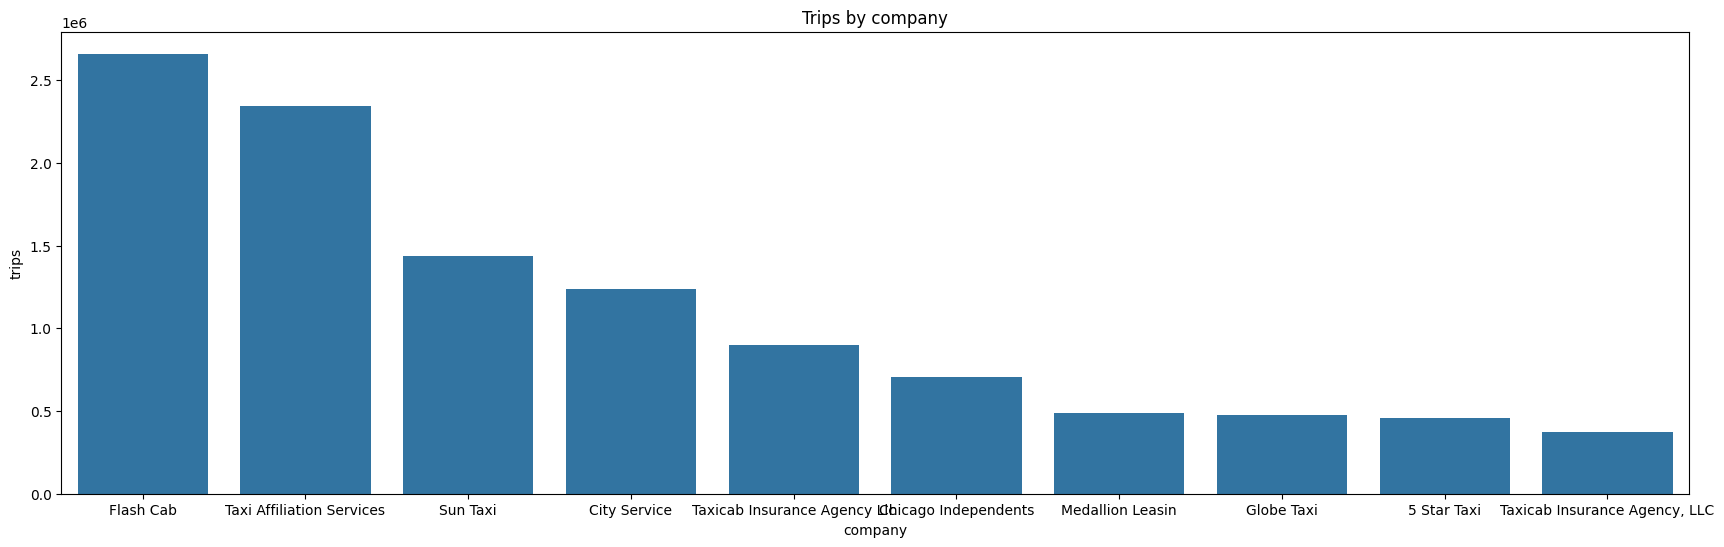

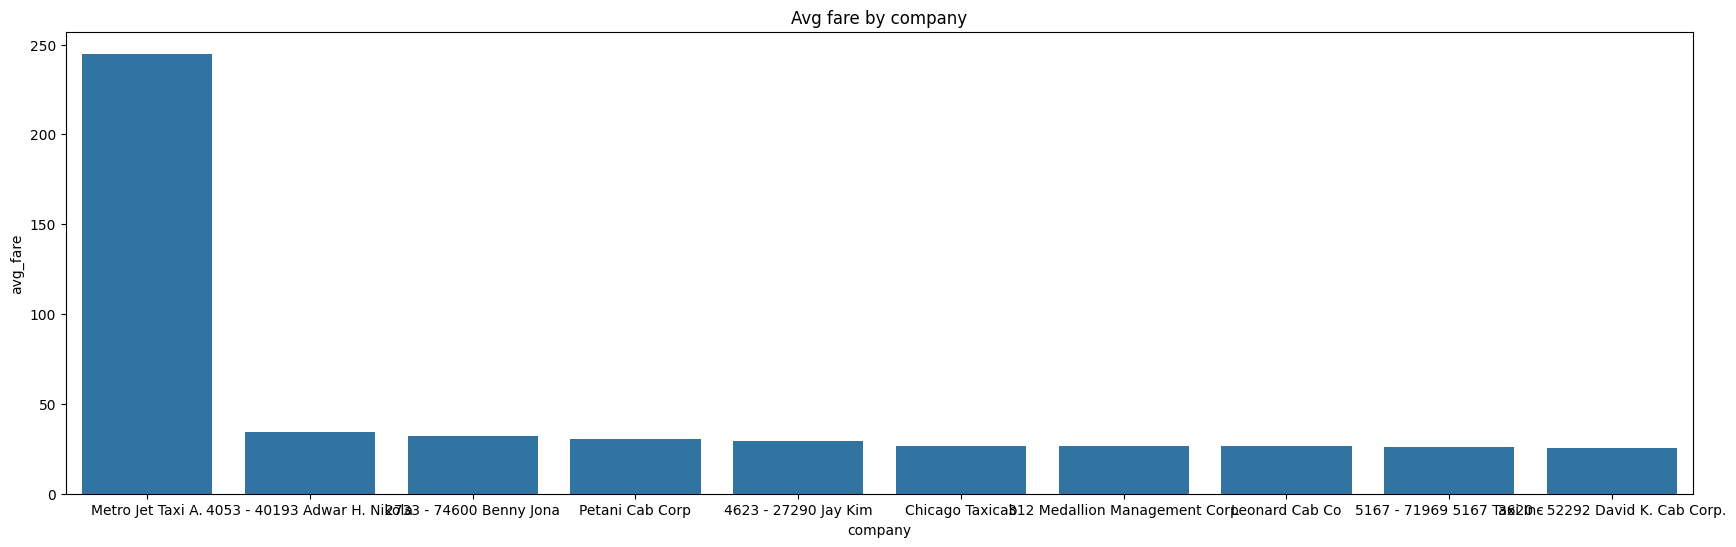

In [10]:
#which comany has the highest trips
plt.figure(figsize=(21,6))
sns.barplot(data = company_data.sort_values(by = 'trips', ascending = False).head(10),x = 'company',y = 'trips')
plt.title('Trips by company')
plt.show()
plt.figure(figsize = (21,6))
sns.barplot(data = company_data.sort_values(by = 'avg_fare', ascending = False).head(10), x = 'company', y = 'avg_fare')
plt.title('Avg fare by company')
plt.show() 

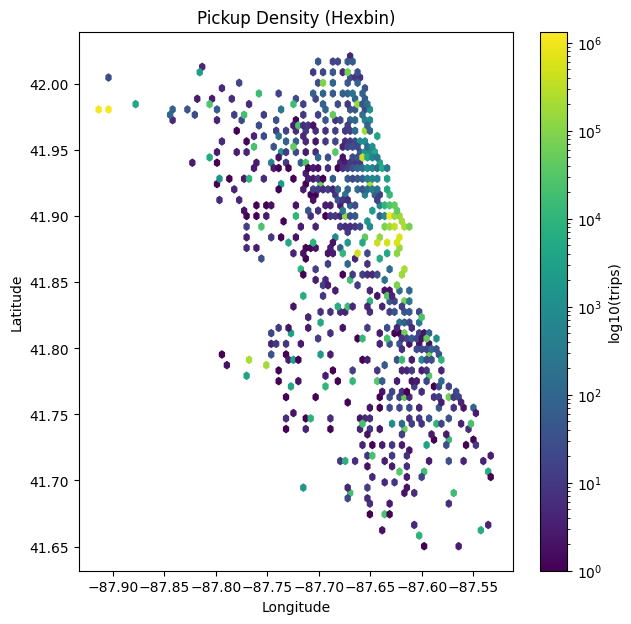

In [11]:
#Plotting the the areas that have the highest trips by hexbin
df_hex = df[['pickup_latitude','pickup_longitude']].dropna()
df_hex = df_hex.query('41.6 <= pickup_latitude <= 42.1 and -88 <= pickup_longitude <= -87.3')

plt.figure(figsize=(7,7))
hb = plt.hexbin(df_hex['pickup_longitude'], df_hex['pickup_latitude'],
                gridsize=80, bins='log')  # gridsize 調密度
plt.xlabel('Longitude'); plt.ylabel('Latitude')
cb = plt.colorbar(hb); cb.set_label('log10(trips)')
plt.title('Pickup Density (Hexbin)')
plt.show()


In [7]:
import folium
from folium.plugins import HeatMap

df_map = df[['pickup_latitude','pickup_longitude']].dropna()

df_map = df_map.query('41.6 <= pickup_latitude <= 42.1 and -88 <= pickup_longitude <= -87.3')


df_s = df_map.sample(n=min(len(df_map), 80_000), random_state=42)

m = folium.Map(location=[41.8781, -87.6298], zoom_start=11, tiles='CartoDB positron')
HeatMap(df_s[['pickup_latitude','pickup_longitude']].values.tolist(),
        radius=8, blur=12, max_zoom=13).add_to(m)
m 


In [ ]:
m.save('chicago_taxi_heatmap.html') 